In [76]:
# 1. Data Handling
import pandas as pd
import numpy as np

# 2. Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# 3. Text Feature Extraction (TF-IDF)
from sklearn.feature_extraction.text import TfidfVectorizer

# 4. Preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# 5. Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# 6. Evaluation Metrics
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

# 7. Warnings (optional – to suppress warnings)
import warnings
warnings.filterwarnings('ignore')

STEP 1- DATA COLLECTION

In [78]:
df = pd.read_csv('ecommerce_furniture_dataset_2024.csv')

In [30]:
df.head()

,productTitle,originalPrice,price,sold,tagText
0,Dresser For Bedroom With 9 Fabric Drawers Ward...,NaN,$46.79,600,Free shipping
1,Outdoor Conversation Set 4 Pieces Patio Furnit...,NaN,$169.72,0,Free shipping
2,Desser For Bedroom With 7 Fabric Drawers Organ...,$78.4,$39.46,7,Free shipping
3,"Modern Accent Boucle Chair,Upholstered Tufted ...",NaN,$111.99,0,Free shipping
4,Small Unit Simple Computer Desk Household Wood...,$48.82,$21.37,1,Free shipping


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   productTitle   2000 non-null   object
 1   originalPrice  487 non-null    object
 2   price          2000 non-null   object
 3   sold           2000 non-null   int64 
 4   tagText        1997 non-null   object
dtypes: int64(1), object(4)
memory usage: 78.3+ KB


In [34]:
df.duplicated().sum()

94

In [36]:
df.describe()

,sold
count,2000.000000
mean,23.493500
std,254.094061
min,0.000000
25%,1.000000
50%,3.000000
75%,9.000000
max,10000.000000


STEP 2- DATA CLEANING

In [38]:
df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)

In [40]:
print(df['price'].dtype)

float64


In [42]:
# Removing duplicates
df.drop_duplicates(inplace=True)

# Confirming removal
print("Remaining duplicates:", df.duplicated().sum())
print("New shape:", df.shape)

Remaining duplicates: 0
New shape: (1906, 5)


In [44]:
# Dropping 'originalPrice' since most values are missing
df.drop('originalPrice', axis=1, inplace=True)

# Dropping rows with missing 'tagText' values
df.dropna(subset=['tagText'], inplace=True)

In [21]:
df.head()

,productTitle,price,sold,tagText
0,Dresser For Bedroom With 9 Fabric Drawers Ward...,46.79,600,Free shipping
1,Outdoor Conversation Set 4 Pieces Patio Furnit...,169.72,0,Free shipping
2,Desser For Bedroom With 7 Fabric Drawers Organ...,39.46,7,Free shipping
3,"Modern Accent Boucle Chair,Upholstered Tufted ...",111.99,0,Free shipping
4,Small Unit Simple Computer Desk Household Wood...,21.37,1,Free shipping


We will classify products into “High-Selling” and “Low-Selling” categories based on their title, price, and tags — so sellers can identify which items are likely to perform well.

Defining the Target

In [46]:
# Creating binary classification target
df['HighSeller'] = df['sold'].apply(lambda x: 1 if x >= 10 else 0)

# Checking distribution
print(df['HighSeller'].value_counts())

HighSeller
0    1428
1     476
Name: count, dtype: int64


STEP 3- EXPLORATORY DATA ANALYSIS

3.1- Distribution of Sold values

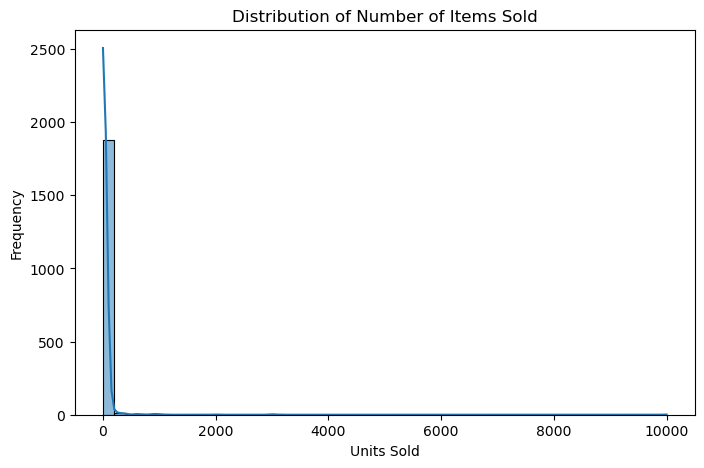

In [48]:
plt.figure(figsize=(8, 5))
sns.histplot(df['sold'], kde=True, bins=50)
plt.title('Distribution of Number of Items Sold')
plt.xlabel('Units Sold')
plt.ylabel('Frequency')
plt.show()

3.2- Relationship between price and sold

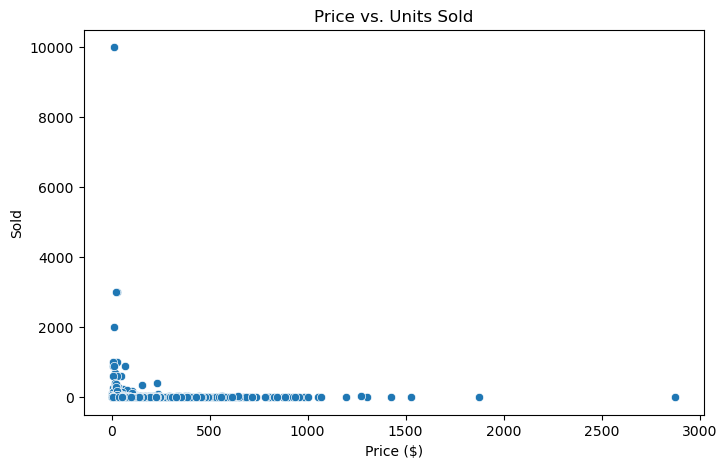

In [50]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x='price', y='sold', data=df)
plt.title('Price vs. Units Sold')
plt.xlabel('Price ($)')
plt.ylabel('Sold')
plt.show()

3.3- Count of High vs Low Sellers (HighSeller)

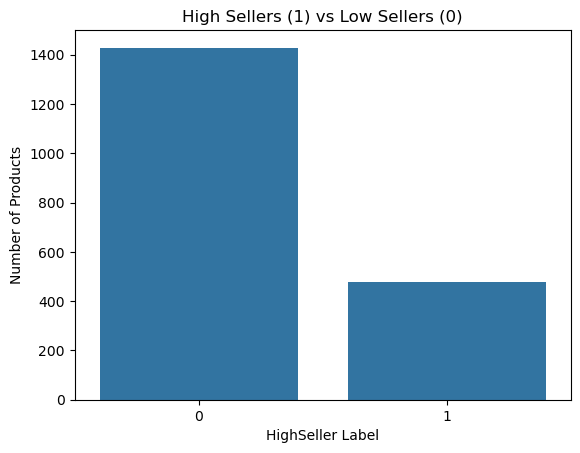

In [52]:
sns.countplot(x='HighSeller', data=df)
plt.title('High Sellers (1) vs Low Sellers (0)')
plt.xlabel('HighSeller Label')
plt.ylabel('Number of Products')
plt.show()

3.4- Shipping Type vs High Seller Rate

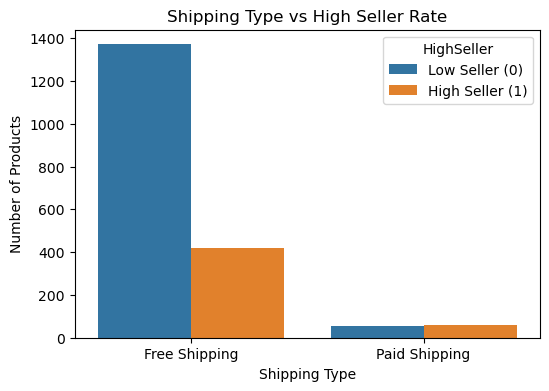

In [54]:
# Simplifying shipping types into broader categories
df['ShippingCategory'] = df['tagText'].apply(
    lambda x: 'Free Shipping' if 'Free' in str(x) else 'Paid Shipping'
)

# Plot HighSeller rate by Shipping Category
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='ShippingCategory', hue='HighSeller')
plt.title("Shipping Type vs High Seller Rate")
plt.xlabel("Shipping Type")
plt.ylabel("Number of Products")
plt.legend(title="HighSeller", labels=["Low Seller (0)", "High Seller (1)"])
plt.show()

3.5 Percentage Plot

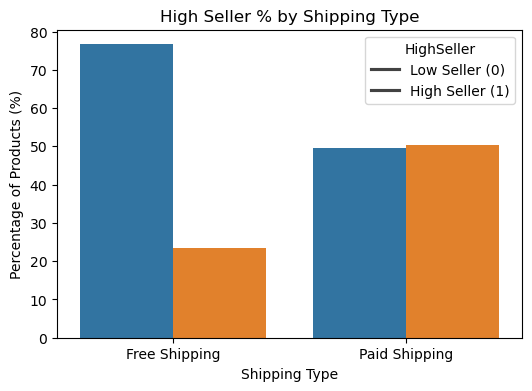

In [57]:
# Calculating percentage of High Sellers per ShippingCategory
shipping_rate = (
    df.groupby('ShippingCategory')['HighSeller']
      .value_counts(normalize=True)
      .mul(100)
      .rename('Percentage')
      .reset_index()
)

# Plotting percentages
plt.figure(figsize=(6,4))
sns.barplot(data=shipping_rate, x='ShippingCategory', y='Percentage', hue='HighSeller')
plt.title("High Seller % by Shipping Type")
plt.ylabel("Percentage of Products (%)")
plt.xlabel("Shipping Type")
plt.legend(title="HighSeller", labels=["Low Seller (0)", "High Seller (1)"])
plt.show()

STEP 4- FEATURE ENGINEERING

4.1- TF-IDF Vectorization on productTitle

In [63]:
# TF-IDF setup
tfidf = TfidfVectorizer(max_features=100, stop_words='english')

# Applying to productTitle
title_tfidf = tfidf.fit_transform(df['productTitle'])

# Converting to DataFrame and merge
tfidf_df = pd.DataFrame(title_tfidf.toarray(), columns=tfidf.get_feature_names_out())
df = pd.concat([df.reset_index(drop=True), tfidf_df.reset_index(drop=True)], axis=1)

# Dropping original text column
df.drop('productTitle', axis=1, inplace=True)

4.2- Encoding tagText 

In [65]:
le = LabelEncoder()
df['tagText'] = le.fit_transform(df['tagText'])

STEP 5- CLASSIFICATION MODELLING

5.1- Preparing X (features) and y (target)

In [67]:
# Dropping target column from features
X = df.drop('HighSeller', axis=1)
y = df['HighSeller']

5.2- Train-test split

In [69]:
# Splitting into 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

5.3 Preprocessing check before Logistic Regression

In [84]:
# Ensuring no missing values
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

# Ensuring all features are numeric
X_train = X_train.apply(pd.to_numeric, errors='coerce').fillna(0)
X_test = X_test.apply(pd.to_numeric, errors='coerce').fillna(0)

# Making sure y is in correct shape (1D)
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("Dtypes:\n", X_train.dtypes.head())

X_train shape: (1523, 104)
y_train shape: (1523,)
Dtypes:
 price               float64
sold                  int64
tagText               int32
ShippingCategory    float64
adjustable          float64
dtype: object


5.4- Training Logistic Regression

In [86]:
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

 5.4- Training Random Forest

In [88]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

STEP 6- MODEL EVALUATION

In [90]:
# Predicting using Logistic Regression
y_pred_log = log_model.predict(X_test)

print("Logistic Regression Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_log))
print("Classification Report:\n", classification_report(y_test, y_pred_log))

Logistic Regression Results:
Accuracy: 1.0
Confusion Matrix:
 [[288   0]
 [  0  93]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       288
           1       1.00      1.00      1.00        93

    accuracy                           1.00       381
   macro avg       1.00      1.00      1.00       381
weighted avg       1.00      1.00      1.00       381



Logistic Regression
Accuracy: 1.0
              precision    recall  f1-score   support

           0      1.000     1.000     1.000       288
           1      1.000     1.000     1.000        93

    accuracy                          1.000       381
   macro avg      1.000     1.000     1.000       381
weighted avg      1.000     1.000     1.000       381



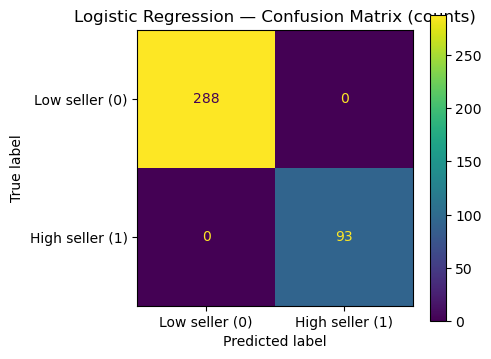

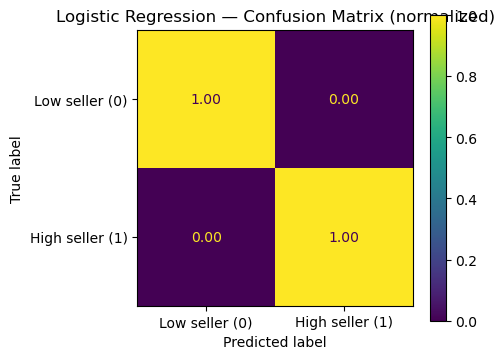

In [94]:
y_pred_log = log_model.predict(X_test)

print("Logistic Regression")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log, digits=3))

fig, ax = plt.subplots(figsize=(5,4))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_log,
    display_labels=["Low seller (0)", "High seller (1)"],
    values_format='d', ax=ax
)
ax.set_title("Logistic Regression — Confusion Matrix (counts)")
plt.tight_layout()
plt.savefig("cm_log_counts.png", dpi=220)

fig, ax = plt.subplots(figsize=(5,4))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_log,
    display_labels=["Low seller (0)", "High seller (1)"],
    normalize='true', values_format='.2f', ax=ax
)
ax.set_title("Logistic Regression — Confusion Matrix (normalized)")
plt.tight_layout()
plt.savefig("cm_log_normalized.png", dpi=220)
plt.show()

In [96]:
# Predicting using Random Forest
y_pred_rf = rf_model.predict(X_test)

print("Random Forest Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

Random Forest Results:
Accuracy: 1.0
Confusion Matrix:
 [[288   0]
 [  0  93]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       288
           1       1.00      1.00      1.00        93

    accuracy                           1.00       381
   macro avg       1.00      1.00      1.00       381
weighted avg       1.00      1.00      1.00       381



Random Forest
Accuracy: 1.0
              precision    recall  f1-score   support

           0      1.000     1.000     1.000       288
           1      1.000     1.000     1.000        93

    accuracy                          1.000       381
   macro avg      1.000     1.000     1.000       381
weighted avg      1.000     1.000     1.000       381



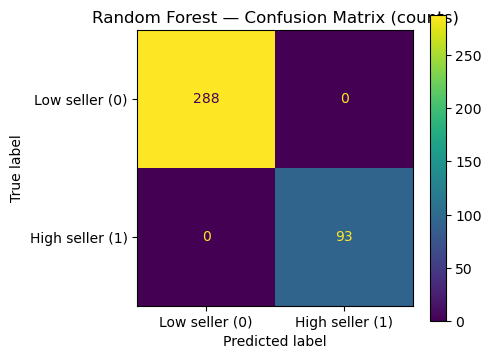

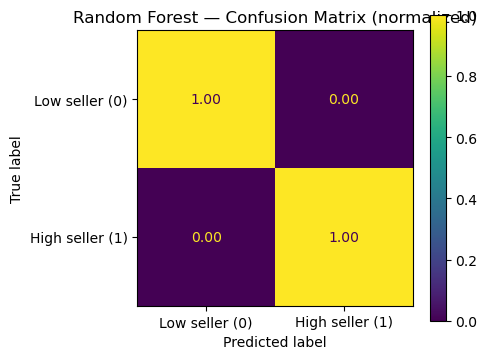

In [98]:
y_pred_rf = rf_model.predict(X_test)

print("Random Forest")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, digits=3))

fig, ax = plt.subplots(figsize=(5,4))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_rf,
    display_labels=["Low seller (0)", "High seller (1)"],
    values_format='d', ax=ax
)
ax.set_title("Random Forest — Confusion Matrix (counts)")
plt.tight_layout()
plt.savefig("cm_rf_counts.png", dpi=220)

fig, ax = plt.subplots(figsize=(5,4))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_rf,
    display_labels=["Low seller (0)", "High seller (1)"],
    normalize='true', values_format='.2f', ax=ax
)
ax.set_title("Random Forest — Confusion Matrix (normalized)")
plt.tight_layout()
plt.savefig("cm_rf_normalized.png", dpi=220)
plt.show()

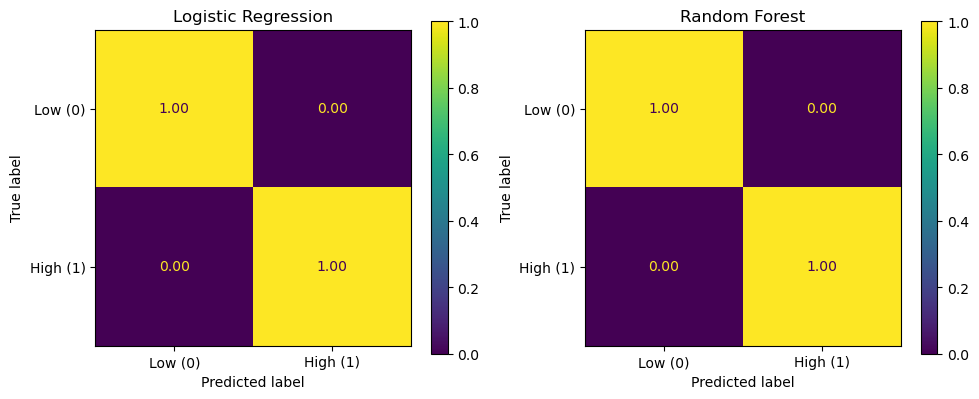

In [100]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_log, normalize='true',
                                        values_format='.2f',
                                        display_labels=["Low (0)", "High (1)"],
                                        ax=axes[0])
axes[0].set_title("Logistic Regression")

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, normalize='true',
                                        values_format='.2f',
                                        display_labels=["Low (0)", "High (1)"],
                                        ax=axes[1])
axes[1].set_title("Random Forest")

plt.tight_layout()
plt.savefig("cm_both_normalized.png", dpi=220)
plt.show()

STEP 7- PROJECT CONCLUSION:

In this project, we analyzed an e-commerce furniture dataset with the goal of predicting whether a furniture product would be a high seller or not, based on its title, price, and shipping type.

We cleaned the dataset by:

⦁	Removing duplicates and missing values
⦁	Converting prices to numeric
⦁	Encoding categorical data
⦁	Creating a new classification target (`Higheictive of demand.

---

Business Insights & Recommendations:

1. Free Shipping Works: Products with “Free shipping” showed a strong link to higher sales. Consider offering it more widely.
2. Price Bands: Most high sellers fall within specific price bands (can be identified through band analysis).
3. Optimize Product Titles: Use keywords like *“modern”, “wood”, “storage”, “compact” — these are common in high-selling titles.
4. Predictive Tagging: Using a classification model like this, sellers can automatically flag products as “likely to be a bestseller” based on just price, title, and tag — help	Insightful conclusions & business actions